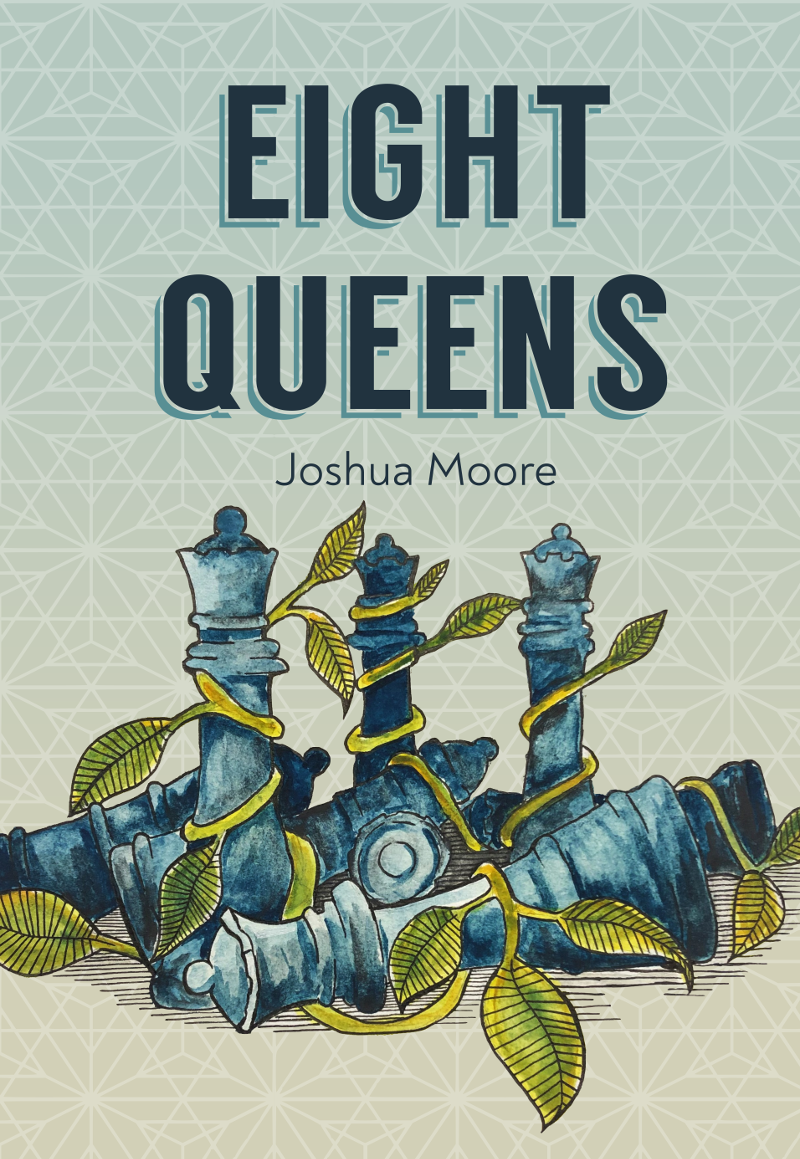</img>

## The Board

Represented below is a chess board, but instead of using nested array notation, we simply count all the fields from 0 to 63. 

- | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 |
---|---|---|---|---|---|---|---|---|
 **0** | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 |
 **1** | 8 | 9 |10 |11 |12 |13 |14 |15 |
 **2** |16 |17 |18 |19 |20 |21 |22 |23 |
 **3** |24 |25 |26 |27 |28 |29 |30 |31 |
 **4** |32 |33 |34 |35 |36 |37 |38 |39 |
 **5** |40 |41 |42 |43 |44 |45 |46 |47 |
 **6** |48 |49 |50 |51 |52 |53 |54 |55 |
 **7** |56 |57 |58 |59 |60 |61 |62 |63 |

A Field is aware of all its neighbors' indices given its own index. Modulo math and integer division take the place of double array indices. 

In [1]:
var Field = class {
  constructor(i){
    
    this.index = i;
    
    // every field has between three and eight neighbors. 
    this.neighbors = {
      'up': Math.floor(i / 8) > 0 ? i - 8 : undefined,
      'down': Math.floor(i / 8) < 7 ? i + 8 : undefined,
      'left': i % 8 > 0 ? i - 1 : undefined,
      'right': i % 8 < 7 ? i + 1 : undefined,
      'up-left': (Math.floor(i / 8) > 0) && (i % 8 > 0) ? i - 9 : undefined,
      'up-right': (Math.floor(i / 8) > 0) && (i % 8 < 7) ? i - 7 : undefined,
      'down-left': (Math.ceil(i / 8) < 7) && (i % 8 > 0) ? i + 7 : undefined,
      'down-right': (Math.ceil(i / 8) < 7) && (i % 8 < 7) ? i + 9 : undefined
    }
  }
}

This range function could have reasonably been called `repeat`. Its range is inklusive, and the subject receives the number as a constructor. The function returns an array with the what_fn created elements, which could be rewritten as a yield statement if this was more critical. 

In [2]:
var range = function(from, till, what_fn){
  var arr = [];
  for(var i=from; i<=till; i++){
    arr.push(what_fn(i));
  }

  return arr;
}

The board contains fields, and one can traverse a queens path across the board by picking an index and a direction, a function that fits neatly into the threatened function returning all threatened fields. 

In [3]:
var Board = class {
  constructor(){
    this.fields = range(0, 63, (i) => {
      return new Field(i)
    })
  }
  
  traverse(index, direction){
    var path = [];
    
    while(index !== undefined){
      path.push(index);
      index = this.fields[index].neighbors[direction];
    }
    
    return path;
  }
  
  threatened(index){
    var field = this.fields[index];
    var t = [
      ...this.traverse(index, 'up'),
      ...this.traverse(index, 'down'),
      ...this.traverse(index, 'left'),
      ...this.traverse(index, 'right'),
      ...this.traverse(index, 'up-left'),
      ...this.traverse(index, 'up-right'),
      ...this.traverse(index, 'down-left'),
      ...this.traverse(index, 'down-right')
    ];
    
    return new Set(t)
  }
}

In [4]:
var board = new Board()

## A few Sanity Tests

In [5]:
console.log(board.traverse(0, 'right'))
console.log(board.traverse(56, 'up'))
console.log(board.traverse(0, 'down'))
console.log(board.traverse(63, 'left'))

var threatened = board.threatened(0)
threatened

[ 0, 1, 2, 3, 4, 5, 6, 7 ]
[ 56, 48, 40, 32, 24, 16, 8, 0 ]
[ 0, 8, 16, 24, 32, 40, 48, 56 ]
[ 63, 62, 61, 60, 59, 58, 57, 56 ]


Set { 0, 8, 16, 24, 32, 40, 48, 56, 1, 2, 3, 4, 5, 6, 7, 9, 18, 27, 36, 45, 54 }

In [6]:
board.traverse(56, 'right')

[ 56, 57, 58, 59, 60, 61, 62, 63 ]

In [7]:
board.traverse(0, 'down-right')

[ 0, 9, 18, 27, 36, 45, 54 ]

In [8]:
board.traverse(56, 'up-right')

[ 56, 49, 42, 35, 28, 21, 14, 7 ]

In [9]:
board.traverse(7, 'down-left')

[ 7, 14, 21, 28, 35, 42, 49 ]

In [10]:
board.traverse(63, 'up-left')

[ 63, 54, 45, 36, 27, 18, 9, 0 ]

## The Meat and Bones

In [11]:
var C = require('js-combinatorics')

The quadrants describe a quarter of the field. There can only be two queens per quarter, or there wouldn't be 8 queens per eight rows and columns. 

In [12]:
var q0 = range(0, 27, i => i).filter(i => i % 8 < 4)
var q1 = range(4, 32, i => i).filter(i => i % 8 >= 4)
var q2 = range(32, 59, i => i).filter(i => i % 8 < 4)
var q3 = range(36, 63, i => i).filter(i => i % 8 >= 4)

In [13]:
[...q0, ...q1, ...q2, ...q3].length == board.fields.length

true

The flat function was one I thought all of javascript had, but it's not implemented cross browser yet. Luckily, there's polyfills for everything here :)

In [14]:
Object.defineProperty(Array.prototype, 'flat', {
    value: function(depth = 1) {
      return this.reduce(function (flat, toFlatten) {
        return flat.concat((Array.isArray(toFlatten) && (depth>1)) ? toFlatten.flat(depth-1) : toFlatten);
      }, []);
    }
});

[]

`q_combos` describes lists of 2-combinations from a list of quadrants, while `potentials` describes the recombined cartesian product of the 2-combinations of quadrants. That means we pick every possible two-combination of fields from each quadrant, filter them by whether they could possibly be a solution to the riddle by not conflicting with each other, then filter the recombined potentials for combinations violating our no threats rule. 

These are all the solutions to the eight queens generated by the above code. 

In [15]:
var makeTable = function(queens){
  var Range = function*(min, max, itemFn){
    var i = min;
    while(i<=max){
      yield itemFn(i);
      i++;
    }
  }

  var tds = Range(0, 63, (i) => {
    var which = queens.indexOf(i);
    if(which === -1){
      return `<td background="transparent"><label>${i}</label><td>`;
    }else{
      return `<td background="transparent"><img class="crown" src="Crown${which+1}.png" alt="Crown"></img><td>`;
    }
  });
  
  var trs = Range(0, 8, () => {
    var str = `<tr>
${tds.next().value}
${tds.next().value}
${tds.next().value}
${tds.next().value}
${tds.next().value}
${tds.next().value}
${tds.next().value}
${tds.next().value}
</tr>`
    return str;
  })
  
  var str = `
<style>
table {
  width: calc(25px * 8);
  height: calc(25px * 8);
}

td {
  width: 25px;
  height: 25px;
  margin: 0;
  padding: 0;
}

img.crown {
  width: 25px;
  height: 25px;
}
</style>
<table>
  ${trs.next().value}
  ${trs.next().value}
  ${trs.next().value}
  ${trs.next().value}
  ${trs.next().value}
  ${trs.next().value}
  ${trs.next().value}
  ${trs.next().value}
</table>`;
  
  return str;
}

In [16]:
$$.html(makeTable([ 10, 25, 5, 22, 48, 59, 39, 44 ]))

0 
 1 
 2 
 3 
 4 
 
 6 
 7 
 
 
 8 
 9 
 
 11 
 12 
 13 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 20 
 21 
 
 23 
 
 
 24 
 
 26 
 27 
 28 
 29 
 30 
 31 
 
 
 32 
 33 
 34 
 35 
 36 
 37 
 38 
 
 
 
 40 
 41 
 42 
 43 
 
 45 
 46 
 47 
 
 
 
 49 
 50 
 51 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 
 60 
 61 
 62 
 63

In [17]:
var q_combos = [q0, q1, q2, q3].map(q => [...C.bigCombination(q, 2).filter(fields => {
  return fields !== undefined && !board.threatened(fields[0]).has(fields[1]);
})])

var potentials = C.cartesianProduct(...q_combos).lazyFilter(potential => {
  return potential.flat().every(i => {
    return potential.flat().filter(j => j != i).every(j => {
      return !board.threatened(i).has(j)
    })
  })
})


var i = 0;
var queens = []
while(queens = potentials.next()){
  console.log(++i, queens.flat())
  $$.display().html(`${makeTable(queens.flat())}<hr>`);
}

1 [ 10, 25, 5, 22, 48, 59, 39, 44 ]


0 
 1 
 2 
 3 
 4 
 
 6 
 7 
 
 
 8 
 9 
 
 11 
 12 
 13 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 20 
 21 
 
 23 
 
 
 24 
 
 26 
 27 
 28 
 29 
 30 
 31 
 
 
 32 
 33 
 34 
 35 
 36 
 37 
 38 
 
 
 
 40 
 41 
 42 
 43 
 
 45 
 46 
 47 
 
 
 
 49 
 50 
 51 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 
 60 
 61 
 62 
 63

2 [ 1, 18, 14, 29, 48, 59, 39, 44 ]


0 
 
 2 
 3 
 4 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 12 
 13 
 
 15 
 
 
 16 
 17 
 
 19 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 28 
 
 30 
 31 
 
 
 32 
 33 
 34 
 35 
 36 
 37 
 38 
 
 
 
 40 
 41 
 42 
 43 
 
 45 
 46 
 47 
 
 
 
 49 
 50 
 51 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 
 60 
 61 
 62 
 63

3 [ 10, 16, 6, 29, 49, 59, 39, 44 ]


0 
 1 
 2 
 3 
 4 
 5 
 
 7 
 
 
 8 
 9 
 
 11 
 12 
 13 
 14 
 15 
 
 
 
 17 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 28 
 
 30 
 31 
 
 
 32 
 33 
 34 
 35 
 36 
 37 
 38 
 
 
 
 40 
 41 
 42 
 43 
 
 45 
 46 
 47 
 
 
 48 
 
 50 
 51 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 
 60 
 61 
 62 
 63

4 [ 16, 26, 4, 14, 51, 57, 39, 45 ]


0 
 1 
 2 
 3 
 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 12 
 13 
 
 15 
 
 
 
 17 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 
 27 
 28 
 29 
 30 
 31 
 
 
 32 
 33 
 34 
 35 
 36 
 37 
 38 
 
 
 
 40 
 41 
 42 
 43 
 44 
 
 46 
 47 
 
 
 48 
 49 
 50 
 
 52 
 53 
 54 
 55 
 
 
 56 
 
 58 
 59 
 60 
 61 
 62 
 63

5 [ 11, 17, 5, 31, 48, 58, 36, 46 ]


0 
 1 
 2 
 3 
 4 
 
 6 
 7 
 
 
 8 
 9 
 10 
 
 12 
 13 
 14 
 15 
 
 
 16 
 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 28 
 29 
 30 
 
 
 
 32 
 33 
 34 
 35 
 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 44 
 45 
 
 47 
 
 
 
 49 
 50 
 51 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 
 59 
 60 
 61 
 62 
 63

6 [ 2, 24, 13, 23, 49, 59, 36, 46 ]


0 
 1 
 
 3 
 4 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 12 
 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 20 
 21 
 22 
 
 
 
 
 25 
 26 
 27 
 28 
 29 
 30 
 31 
 
 
 32 
 33 
 34 
 35 
 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 44 
 45 
 
 47 
 
 
 48 
 
 50 
 51 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 
 60 
 61 
 62 
 63

7 [ 10, 16, 5, 30, 49, 59, 36, 47 ]


0 
 1 
 2 
 3 
 4 
 
 6 
 7 
 
 
 8 
 9 
 
 11 
 12 
 13 
 14 
 15 
 
 
 
 17 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 28 
 29 
 
 31 
 
 
 32 
 33 
 34 
 35 
 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 44 
 45 
 46 
 
 
 
 48 
 
 50 
 51 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 
 60 
 61 
 62 
 63

8 [ 18, 24, 6, 12, 49, 59, 37, 47 ]


0 
 1 
 2 
 3 
 4 
 5 
 
 7 
 
 
 8 
 9 
 10 
 11 
 
 13 
 14 
 15 
 
 
 16 
 17 
 
 19 
 20 
 21 
 22 
 23 
 
 
 
 25 
 26 
 27 
 28 
 29 
 30 
 31 
 
 
 32 
 33 
 34 
 35 
 36 
 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 44 
 45 
 46 
 
 
 
 48 
 
 50 
 51 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 
 60 
 61 
 62 
 63

9 [ 11, 24, 5, 22, 41, 58, 39, 52 ]


0 
 1 
 2 
 3 
 4 
 
 6 
 7 
 
 
 8 
 9 
 10 
 
 12 
 13 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 20 
 21 
 
 23 
 
 
 
 25 
 26 
 27 
 28 
 29 
 30 
 31 
 
 
 32 
 33 
 34 
 35 
 36 
 37 
 38 
 
 
 
 40 
 
 42 
 43 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 50 
 51 
 
 53 
 54 
 55 
 
 
 56 
 57 
 
 59 
 60 
 61 
 62 
 63

10 [ 0, 19, 14, 29, 41, 58, 39, 52 ]


1 
 2 
 3 
 4 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 12 
 13 
 
 15 
 
 
 16 
 17 
 18 
 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 28 
 
 30 
 31 
 
 
 32 
 33 
 34 
 35 
 36 
 37 
 38 
 
 
 
 40 
 
 42 
 43 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 50 
 51 
 
 53 
 54 
 55 
 
 
 56 
 57 
 
 59 
 60 
 61 
 62 
 63

11 [ 3, 26, 13, 23, 32, 57, 46, 52 ]


0 
 1 
 2 
 
 4 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 12 
 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 20 
 21 
 22 
 
 
 
 24 
 25 
 
 27 
 28 
 29 
 30 
 31 
 
 
 
 33 
 34 
 35 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 44 
 45 
 
 47 
 
 
 48 
 49 
 50 
 51 
 
 53 
 54 
 55 
 
 
 56 
 
 58 
 59 
 60 
 61 
 62 
 63

12 [ 2, 24, 13, 23, 35, 57, 46, 52 ]


0 
 1 
 
 3 
 4 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 12 
 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 20 
 21 
 22 
 
 
 
 
 25 
 26 
 27 
 28 
 29 
 30 
 31 
 
 
 32 
 33 
 34 
 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 44 
 45 
 
 47 
 
 
 48 
 49 
 50 
 51 
 
 53 
 54 
 55 
 
 
 56 
 
 58 
 59 
 60 
 61 
 62 
 63

13 [ 17, 27, 5, 15, 32, 58, 46, 52 ]


0 
 1 
 2 
 3 
 4 
 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 12 
 13 
 14 
 
 
 
 16 
 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 
 28 
 29 
 30 
 31 
 
 
 
 33 
 34 
 35 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 44 
 45 
 
 47 
 
 
 48 
 49 
 50 
 51 
 
 53 
 54 
 55 
 
 
 56 
 57 
 
 59 
 60 
 61 
 62 
 63

14 [ 9, 24, 5, 22, 35, 58, 47, 52 ]


0 
 1 
 2 
 3 
 4 
 
 6 
 7 
 
 
 8 
 
 10 
 11 
 12 
 13 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 20 
 21 
 
 23 
 
 
 
 25 
 26 
 27 
 28 
 29 
 30 
 31 
 
 
 32 
 33 
 34 
 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 44 
 45 
 46 
 
 
 
 48 
 49 
 50 
 51 
 
 53 
 54 
 55 
 
 
 56 
 57 
 
 59 
 60 
 61 
 62 
 63

15 [ 3, 16, 14, 31, 41, 58, 36, 53 ]


0 
 1 
 2 
 
 4 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 12 
 13 
 
 15 
 
 
 
 17 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 28 
 29 
 30 
 
 
 
 32 
 33 
 34 
 35 
 
 37 
 38 
 39 
 
 
 40 
 
 42 
 43 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 50 
 51 
 52 
 
 54 
 55 
 
 
 56 
 57 
 
 59 
 60 
 61 
 62 
 63

16 [ 10, 25, 6, 23, 40, 59, 36, 53 ]


0 
 1 
 2 
 3 
 4 
 5 
 
 7 
 
 
 8 
 9 
 
 11 
 12 
 13 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 20 
 21 
 22 
 
 
 
 24 
 
 26 
 27 
 28 
 29 
 30 
 31 
 
 
 32 
 33 
 34 
 35 
 
 37 
 38 
 39 
 
 
 
 41 
 42 
 43 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 50 
 51 
 52 
 
 54 
 55 
 
 
 56 
 57 
 58 
 
 60 
 61 
 62 
 63

17 [ 10, 27, 4, 23, 40, 57, 38, 53 ]


0 
 1 
 2 
 3 
 
 5 
 6 
 7 
 
 
 8 
 9 
 
 11 
 12 
 13 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 20 
 21 
 22 
 
 
 
 24 
 25 
 26 
 
 28 
 29 
 30 
 31 
 
 
 32 
 33 
 34 
 35 
 36 
 37 
 
 39 
 
 
 
 41 
 42 
 43 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 50 
 51 
 52 
 
 54 
 55 
 
 
 56 
 
 58 
 59 
 60 
 61 
 62 
 63

18 [ 19, 24, 4, 15, 41, 58, 38, 53 ]


0 
 1 
 2 
 3 
 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 12 
 13 
 14 
 
 
 
 16 
 17 
 18 
 
 20 
 21 
 22 
 23 
 
 
 
 25 
 26 
 27 
 28 
 29 
 30 
 31 
 
 
 32 
 33 
 34 
 35 
 36 
 37 
 
 39 
 
 
 40 
 
 42 
 43 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 50 
 51 
 52 
 
 54 
 55 
 
 
 56 
 57 
 
 59 
 60 
 61 
 62 
 63

19 [ 3, 16, 15, 28, 41, 58, 38, 53 ]


0 
 1 
 2 
 
 4 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 12 
 13 
 14 
 
 
 
 
 17 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 
 29 
 30 
 31 
 
 
 32 
 33 
 34 
 35 
 36 
 37 
 
 39 
 
 
 40 
 
 42 
 43 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 50 
 51 
 52 
 
 54 
 55 
 
 
 56 
 57 
 
 59 
 60 
 61 
 62 
 63

20 [ 9, 19, 4, 30, 34, 56, 47, 53 ]


0 
 1 
 2 
 3 
 
 5 
 6 
 7 
 
 
 8 
 
 10 
 11 
 12 
 13 
 14 
 15 
 
 
 16 
 17 
 18 
 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 28 
 29 
 
 31 
 
 
 32 
 33 
 
 35 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 44 
 45 
 46 
 
 
 
 48 
 49 
 50 
 51 
 52 
 
 54 
 55 
 
 
 
 57 
 58 
 59 
 60 
 61 
 62 
 63

21 [ 19, 24, 4, 14, 34, 57, 47, 53 ]


0 
 1 
 2 
 3 
 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 12 
 13 
 
 15 
 
 
 16 
 17 
 18 
 
 20 
 21 
 22 
 23 
 
 
 
 25 
 26 
 27 
 28 
 29 
 30 
 31 
 
 
 32 
 33 
 
 35 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 44 
 45 
 46 
 
 
 
 48 
 49 
 50 
 51 
 52 
 
 54 
 55 
 
 
 56 
 
 58 
 59 
 60 
 61 
 62 
 63

22 [ 1, 27, 12, 22, 32, 58, 47, 53 ]


0 
 
 2 
 3 
 4 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 
 13 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 20 
 21 
 
 23 
 
 
 24 
 25 
 26 
 
 28 
 29 
 30 
 31 
 
 
 
 33 
 34 
 35 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 44 
 45 
 46 
 
 
 
 48 
 49 
 50 
 51 
 52 
 
 54 
 55 
 
 
 56 
 57 
 
 59 
 60 
 61 
 62 
 63

23 [ 3, 9, 22, 28, 32, 58, 47, 53 ]


0 
 1 
 2 
 
 4 
 5 
 6 
 7 
 
 
 8 
 
 10 
 11 
 12 
 13 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 20 
 21 
 
 23 
 
 
 24 
 25 
 26 
 27 
 
 29 
 30 
 31 
 
 
 
 33 
 34 
 35 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 44 
 45 
 46 
 
 
 
 48 
 49 
 50 
 51 
 52 
 
 54 
 55 
 
 
 56 
 57 
 
 59 
 60 
 61 
 62 
 63

24 [ 16, 27, 4, 14, 33, 58, 47, 53 ]


0 
 1 
 2 
 3 
 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 12 
 13 
 
 15 
 
 
 
 17 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 
 28 
 29 
 30 
 31 
 
 
 32 
 
 34 
 35 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 44 
 45 
 46 
 
 
 
 48 
 49 
 50 
 51 
 52 
 
 54 
 55 
 
 
 56 
 57 
 
 59 
 60 
 61 
 62 
 63

25 [ 10, 16, 4, 30, 33, 59, 47, 53 ]


0 
 1 
 2 
 3 
 
 5 
 6 
 7 
 
 
 8 
 9 
 
 11 
 12 
 13 
 14 
 15 
 
 
 
 17 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 28 
 29 
 
 31 
 
 
 32 
 
 34 
 35 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 44 
 45 
 46 
 
 
 
 48 
 49 
 50 
 51 
 52 
 
 54 
 55 
 
 
 56 
 57 
 58 
 
 60 
 61 
 62 
 63

26 [ 1, 24, 12, 22, 34, 59, 47, 53 ]


0 
 
 2 
 3 
 4 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 
 13 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 20 
 21 
 
 23 
 
 
 
 25 
 26 
 27 
 28 
 29 
 30 
 31 
 
 
 32 
 33 
 
 35 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 44 
 45 
 46 
 
 
 
 48 
 49 
 50 
 51 
 52 
 
 54 
 55 
 
 
 56 
 57 
 58 
 
 60 
 61 
 62 
 63

27 [ 2, 17, 12, 31, 43, 56, 37, 54 ]


0 
 1 
 
 3 
 4 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 
 13 
 14 
 15 
 
 
 16 
 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 28 
 29 
 30 
 
 
 
 32 
 33 
 34 
 35 
 36 
 
 38 
 39 
 
 
 40 
 41 
 42 
 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 50 
 51 
 52 
 53 
 
 55 
 
 
 
 57 
 58 
 59 
 60 
 61 
 62 
 63

28 [ 3, 8, 20, 31, 42, 57, 37, 54 ]


0 
 1 
 2 
 
 4 
 5 
 6 
 7 
 
 
 
 9 
 10 
 11 
 12 
 13 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 28 
 29 
 30 
 
 
 
 32 
 33 
 34 
 35 
 36 
 
 38 
 39 
 
 
 40 
 41 
 
 43 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 50 
 51 
 52 
 53 
 
 55 
 
 
 56 
 
 58 
 59 
 60 
 61 
 62 
 63

29 [ 11, 16, 5, 28, 41, 58, 39, 54 ]


0 
 1 
 2 
 3 
 4 
 
 6 
 7 
 
 
 8 
 9 
 10 
 
 12 
 13 
 14 
 15 
 
 
 
 17 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 
 29 
 30 
 31 
 
 
 32 
 33 
 34 
 35 
 36 
 37 
 38 
 
 
 
 40 
 
 42 
 43 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 50 
 51 
 52 
 53 
 
 55 
 
 
 56 
 57 
 
 59 
 60 
 61 
 62 
 63

30 [ 8, 19, 4, 29, 41, 58, 39, 54 ]


0 
 1 
 2 
 3 
 
 5 
 6 
 7 
 
 
 
 9 
 10 
 11 
 12 
 13 
 14 
 15 
 
 
 16 
 17 
 18 
 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 28 
 
 30 
 31 
 
 
 32 
 33 
 34 
 35 
 36 
 37 
 38 
 
 
 
 40 
 
 42 
 43 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 50 
 51 
 52 
 53 
 
 55 
 
 
 56 
 57 
 
 59 
 60 
 61 
 62 
 63

31 [ 2, 17, 13, 28, 40, 59, 39, 54 ]


0 
 1 
 
 3 
 4 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 12 
 
 14 
 15 
 
 
 16 
 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 
 29 
 30 
 31 
 
 
 32 
 33 
 34 
 35 
 36 
 37 
 38 
 
 
 
 
 41 
 42 
 43 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 50 
 51 
 52 
 53 
 
 55 
 
 
 56 
 57 
 58 
 
 60 
 61 
 62 
 63

32 [ 8, 25, 5, 20, 42, 59, 39, 54 ]


0 
 1 
 2 
 3 
 4 
 
 6 
 7 
 
 
 
 9 
 10 
 11 
 12 
 13 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 
 21 
 22 
 23 
 
 
 24 
 
 26 
 27 
 28 
 29 
 30 
 31 
 
 
 32 
 33 
 34 
 35 
 36 
 37 
 38 
 
 
 
 40 
 41 
 
 43 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 50 
 51 
 52 
 53 
 
 55 
 
 
 56 
 57 
 58 
 
 60 
 61 
 62 
 63

33 [ 10, 16, 7, 29, 33, 59, 44, 54 ]


0 
 1 
 2 
 3 
 4 
 5 
 6 
 
 
 
 8 
 9 
 
 11 
 12 
 13 
 14 
 15 
 
 
 
 17 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 28 
 
 30 
 31 
 
 
 32 
 
 34 
 35 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 
 45 
 46 
 47 
 
 
 48 
 49 
 50 
 51 
 52 
 53 
 
 55 
 
 
 56 
 57 
 58 
 
 60 
 61 
 62 
 63

34 [ 1, 24, 15, 21, 34, 59, 44, 54 ]


0 
 
 2 
 3 
 4 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 12 
 13 
 14 
 
 
 
 16 
 17 
 18 
 19 
 20 
 
 22 
 23 
 
 
 
 25 
 26 
 27 
 28 
 29 
 30 
 31 
 
 
 32 
 33 
 
 35 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 
 45 
 46 
 47 
 
 
 48 
 49 
 50 
 51 
 52 
 53 
 
 55 
 
 
 56 
 57 
 58 
 
 60 
 61 
 62 
 63

35 [ 2, 17, 13, 30, 40, 59, 36, 55 ]


0 
 1 
 
 3 
 4 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 12 
 
 14 
 15 
 
 
 16 
 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 28 
 29 
 
 31 
 
 
 32 
 33 
 34 
 35 
 
 37 
 38 
 39 
 
 
 
 41 
 42 
 43 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 50 
 51 
 52 
 53 
 54 
 
 
 
 56 
 57 
 58 
 
 60 
 61 
 62 
 63

36 [ 9, 24, 4, 21, 43, 58, 38, 55 ]


0 
 1 
 2 
 3 
 
 5 
 6 
 7 
 
 
 8 
 
 10 
 11 
 12 
 13 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 20 
 
 22 
 23 
 
 
 
 25 
 26 
 27 
 28 
 29 
 30 
 31 
 
 
 32 
 33 
 34 
 35 
 36 
 37 
 
 39 
 
 
 40 
 41 
 42 
 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 50 
 51 
 52 
 53 
 54 
 
 
 
 56 
 57 
 
 59 
 60 
 61 
 62 
 63

37 [ 9, 24, 5, 22, 34, 59, 44, 55 ]


0 
 1 
 2 
 3 
 4 
 
 6 
 7 
 
 
 8 
 
 10 
 11 
 12 
 13 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 20 
 21 
 
 23 
 
 
 
 25 
 26 
 27 
 28 
 29 
 30 
 31 
 
 
 32 
 33 
 
 35 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 
 45 
 46 
 47 
 
 
 48 
 49 
 50 
 51 
 52 
 53 
 54 
 
 
 
 56 
 57 
 58 
 
 60 
 61 
 62 
 63

38 [ 3, 26, 14, 20, 32, 57, 45, 55 ]


0 
 1 
 2 
 
 4 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 12 
 13 
 
 15 
 
 
 16 
 17 
 18 
 19 
 
 21 
 22 
 23 
 
 
 24 
 25 
 
 27 
 28 
 29 
 30 
 31 
 
 
 
 33 
 34 
 35 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 44 
 
 46 
 47 
 
 
 48 
 49 
 50 
 51 
 52 
 53 
 54 
 
 
 
 56 
 
 58 
 59 
 60 
 61 
 62 
 63

39 [ 2, 17, 14, 31, 43, 48, 37, 60 ]


0 
 1 
 
 3 
 4 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 12 
 13 
 
 15 
 
 
 16 
 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 28 
 29 
 30 
 
 
 
 32 
 33 
 34 
 35 
 36 
 
 38 
 39 
 
 
 40 
 41 
 42 
 
 44 
 45 
 46 
 47 
 
 
 
 49 
 50 
 51 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 59 
 
 61 
 62 
 63

40 [ 8, 18, 6, 31, 43, 49, 37, 60 ]


0 
 1 
 2 
 3 
 4 
 5 
 
 7 
 
 
 
 9 
 10 
 11 
 12 
 13 
 14 
 15 
 
 
 16 
 17 
 
 19 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 28 
 29 
 30 
 
 
 
 32 
 33 
 34 
 35 
 36 
 
 38 
 39 
 
 
 40 
 41 
 42 
 
 44 
 45 
 46 
 47 
 
 
 48 
 
 50 
 51 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 59 
 
 61 
 62 
 63

41 [ 11, 17, 6, 31, 40, 50, 37, 60 ]


0 
 1 
 2 
 3 
 4 
 5 
 
 7 
 
 
 8 
 9 
 10 
 
 12 
 13 
 14 
 15 
 
 
 16 
 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 28 
 29 
 30 
 
 
 
 32 
 33 
 34 
 35 
 36 
 
 38 
 39 
 
 
 
 41 
 42 
 43 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 
 51 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 59 
 
 61 
 62 
 63

42 [ 0, 26, 13, 23, 43, 49, 38, 60 ]


1 
 2 
 3 
 4 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 12 
 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 20 
 21 
 22 
 
 
 
 24 
 25 
 
 27 
 28 
 29 
 30 
 31 
 
 
 32 
 33 
 34 
 35 
 36 
 37 
 
 39 
 
 
 40 
 41 
 42 
 
 44 
 45 
 46 
 47 
 
 
 48 
 
 50 
 51 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 59 
 
 61 
 62 
 63

43 [ 3, 25, 13, 23, 40, 50, 38, 60 ]


0 
 1 
 2 
 
 4 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 12 
 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 20 
 21 
 22 
 
 
 
 24 
 
 26 
 27 
 28 
 29 
 30 
 31 
 
 
 32 
 33 
 34 
 35 
 36 
 37 
 
 39 
 
 
 
 41 
 42 
 43 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 
 51 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 59 
 
 61 
 62 
 63

44 [ 2, 19, 15, 30, 32, 49, 45, 60 ]


0 
 1 
 
 3 
 4 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 12 
 13 
 14 
 
 
 
 16 
 17 
 18 
 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 28 
 29 
 
 31 
 
 
 
 33 
 34 
 35 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 44 
 
 46 
 47 
 
 
 48 
 
 50 
 51 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 59 
 
 61 
 62 
 63

45 [ 10, 25, 5, 22, 35, 48, 47, 60 ]


0 
 1 
 2 
 3 
 4 
 
 6 
 7 
 
 
 8 
 9 
 
 11 
 12 
 13 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 20 
 21 
 
 23 
 
 
 24 
 
 26 
 27 
 28 
 29 
 30 
 31 
 
 
 32 
 33 
 34 
 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 44 
 45 
 46 
 
 
 
 
 49 
 50 
 51 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 59 
 
 61 
 62 
 63

46 [ 10, 27, 5, 22, 32, 49, 47, 60 ]


0 
 1 
 2 
 3 
 4 
 
 6 
 7 
 
 
 8 
 9 
 
 11 
 12 
 13 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 20 
 21 
 
 23 
 
 
 24 
 25 
 26 
 
 28 
 29 
 30 
 31 
 
 
 
 33 
 34 
 35 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 44 
 45 
 46 
 
 
 
 48 
 
 50 
 51 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 59 
 
 61 
 62 
 63

47 [ 1, 16, 13, 30, 35, 50, 47, 60 ]


0 
 
 2 
 3 
 4 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 12 
 
 14 
 15 
 
 
 
 17 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 28 
 29 
 
 31 
 
 
 32 
 33 
 34 
 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 44 
 45 
 46 
 
 
 
 48 
 49 
 
 51 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 59 
 
 61 
 62 
 63

48 [ 1, 11, 21, 31, 34, 40, 54, 60 ]


0 
 
 2 
 3 
 4 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 
 12 
 13 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 20 
 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 28 
 29 
 30 
 
 
 
 32 
 33 
 
 35 
 36 
 37 
 38 
 39 
 
 
 
 41 
 42 
 43 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 50 
 51 
 52 
 53 
 
 55 
 
 
 56 
 57 
 58 
 59 
 
 61 
 62 
 63

49 [ 2, 25, 13, 23, 35, 40, 54, 60 ]


0 
 1 
 
 3 
 4 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 12 
 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 20 
 21 
 22 
 
 
 
 24 
 
 26 
 27 
 28 
 29 
 30 
 31 
 
 
 32 
 33 
 34 
 
 36 
 37 
 38 
 39 
 
 
 
 41 
 42 
 43 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 50 
 51 
 52 
 53 
 
 55 
 
 
 56 
 57 
 58 
 59 
 
 61 
 62 
 63

50 [ 10, 16, 5, 31, 35, 41, 54, 60 ]


0 
 1 
 2 
 3 
 4 
 
 6 
 7 
 
 
 8 
 9 
 
 11 
 12 
 13 
 14 
 15 
 
 
 
 17 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 28 
 29 
 30 
 
 
 
 32 
 33 
 34 
 
 36 
 37 
 38 
 39 
 
 
 40 
 
 42 
 43 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 50 
 51 
 52 
 53 
 
 55 
 
 
 56 
 57 
 58 
 59 
 
 61 
 62 
 63

51 [ 1, 26, 13, 23, 32, 43, 54, 60 ]


0 
 
 2 
 3 
 4 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 12 
 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 20 
 21 
 22 
 
 
 
 24 
 25 
 
 27 
 28 
 29 
 30 
 31 
 
 
 
 33 
 34 
 35 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 50 
 51 
 52 
 53 
 
 55 
 
 
 56 
 57 
 58 
 59 
 
 61 
 62 
 63

52 [ 9, 26, 6, 21, 32, 43, 55, 60 ]


0 
 1 
 2 
 3 
 4 
 5 
 
 7 
 
 
 8 
 
 10 
 11 
 12 
 13 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 20 
 
 22 
 23 
 
 
 24 
 25 
 
 27 
 28 
 29 
 30 
 31 
 
 
 
 33 
 34 
 35 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 50 
 51 
 52 
 53 
 54 
 
 
 
 56 
 57 
 58 
 59 
 
 61 
 62 
 63

53 [ 2, 17, 13, 30, 32, 43, 55, 60 ]


0 
 1 
 
 3 
 4 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 12 
 
 14 
 15 
 
 
 16 
 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 28 
 29 
 
 31 
 
 
 
 33 
 34 
 35 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 50 
 51 
 52 
 53 
 54 
 
 
 
 56 
 57 
 58 
 59 
 
 61 
 62 
 63

54 [ 2, 17, 14, 31, 40, 51, 36, 61 ]


0 
 1 
 
 3 
 4 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 12 
 13 
 
 15 
 
 
 16 
 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 28 
 29 
 30 
 
 
 
 32 
 33 
 34 
 35 
 
 37 
 38 
 39 
 
 
 
 41 
 42 
 43 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 50 
 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 59 
 60 
 
 62 
 63

55 [ 3, 9, 23, 28, 40, 50, 38, 61 ]


0 
 1 
 2 
 
 4 
 5 
 6 
 7 
 
 
 8 
 
 10 
 11 
 12 
 13 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 20 
 21 
 22 
 
 
 
 24 
 25 
 26 
 27 
 
 29 
 30 
 31 
 
 
 32 
 33 
 34 
 35 
 36 
 37 
 
 39 
 
 
 
 41 
 42 
 43 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 
 51 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 59 
 60 
 
 62 
 63

56 [ 17, 27, 4, 14, 40, 50, 39, 61 ]


0 
 1 
 2 
 3 
 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 12 
 13 
 
 15 
 
 
 16 
 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 
 28 
 29 
 30 
 31 
 
 
 32 
 33 
 34 
 35 
 36 
 37 
 38 
 
 
 
 
 41 
 42 
 43 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 
 51 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 59 
 60 
 
 62 
 63

57 [ 11, 17, 6, 28, 40, 50, 39, 61 ]


0 
 1 
 2 
 3 
 4 
 5 
 
 7 
 
 
 8 
 9 
 10 
 
 12 
 13 
 14 
 15 
 
 
 16 
 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 
 29 
 30 
 31 
 
 
 32 
 33 
 34 
 35 
 36 
 37 
 38 
 
 
 
 
 41 
 42 
 43 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 
 51 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 59 
 60 
 
 62 
 63

58 [ 2, 8, 22, 28, 41, 51, 39, 61 ]


0 
 1 
 
 3 
 4 
 5 
 6 
 7 
 
 
 
 9 
 10 
 11 
 12 
 13 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 20 
 21 
 
 23 
 
 
 24 
 25 
 26 
 27 
 
 29 
 30 
 31 
 
 
 32 
 33 
 34 
 35 
 36 
 37 
 38 
 
 
 
 40 
 
 42 
 43 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 50 
 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 59 
 60 
 
 62 
 63

59 [ 3, 18, 14, 31, 33, 48, 44, 61 ]


0 
 1 
 2 
 
 4 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 12 
 13 
 
 15 
 
 
 16 
 17 
 
 19 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 28 
 29 
 30 
 
 
 
 32 
 
 34 
 35 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 
 45 
 46 
 47 
 
 
 
 49 
 50 
 51 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 59 
 60 
 
 62 
 63

60 [ 3, 26, 15, 20, 32, 49, 46, 61 ]


0 
 1 
 2 
 
 4 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 12 
 13 
 14 
 
 
 
 16 
 17 
 18 
 19 
 
 21 
 22 
 23 
 
 
 24 
 25 
 
 27 
 28 
 29 
 30 
 31 
 
 
 
 33 
 34 
 35 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 44 
 45 
 
 47 
 
 
 48 
 
 50 
 51 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 59 
 60 
 
 62 
 63

61 [ 2, 27, 12, 23, 32, 49, 46, 61 ]


0 
 1 
 
 3 
 4 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 
 13 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 20 
 21 
 22 
 
 
 
 24 
 25 
 26 
 
 28 
 29 
 30 
 31 
 
 
 
 33 
 34 
 35 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 44 
 45 
 
 47 
 
 
 48 
 
 50 
 51 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 59 
 60 
 
 62 
 63

62 [ 8, 27, 4, 23, 33, 50, 46, 61 ]


0 
 1 
 2 
 3 
 
 5 
 6 
 7 
 
 
 
 9 
 10 
 11 
 12 
 13 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 20 
 21 
 22 
 
 
 
 24 
 25 
 26 
 
 28 
 29 
 30 
 31 
 
 
 32 
 
 34 
 35 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 44 
 45 
 
 47 
 
 
 48 
 49 
 
 51 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 59 
 60 
 
 62 
 63

63 [ 3, 8, 20, 31, 33, 50, 46, 61 ]


0 
 1 
 2 
 
 4 
 5 
 6 
 7 
 
 
 
 9 
 10 
 11 
 12 
 13 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 28 
 29 
 30 
 
 
 
 32 
 
 34 
 35 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 44 
 45 
 
 47 
 
 
 48 
 49 
 
 51 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 59 
 60 
 
 62 
 63

64 [ 9, 24, 4, 23, 35, 50, 46, 61 ]


0 
 1 
 2 
 3 
 
 5 
 6 
 7 
 
 
 8 
 
 10 
 11 
 12 
 13 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 20 
 21 
 22 
 
 
 
 
 25 
 26 
 27 
 28 
 29 
 30 
 31 
 
 
 32 
 33 
 34 
 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 44 
 45 
 
 47 
 
 
 48 
 49 
 
 51 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 59 
 60 
 
 62 
 63

65 [ 9, 26, 7, 20, 32, 51, 46, 61 ]


0 
 1 
 2 
 3 
 4 
 5 
 6 
 
 
 
 8 
 
 10 
 11 
 12 
 13 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 
 21 
 22 
 23 
 
 
 24 
 25 
 
 27 
 28 
 29 
 30 
 31 
 
 
 
 33 
 34 
 35 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 44 
 45 
 
 47 
 
 
 48 
 49 
 50 
 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 59 
 60 
 
 62 
 63

66 [ 2, 17, 12, 31, 32, 51, 46, 61 ]


0 
 1 
 
 3 
 4 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 
 13 
 14 
 15 
 
 
 16 
 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 28 
 29 
 30 
 
 
 
 
 33 
 34 
 35 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 44 
 45 
 
 47 
 
 
 48 
 49 
 50 
 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 59 
 60 
 
 62 
 63

67 [ 2, 24, 12, 22, 35, 41, 55, 61 ]


0 
 1 
 
 3 
 4 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 
 13 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 20 
 21 
 
 23 
 
 
 
 25 
 26 
 27 
 28 
 29 
 30 
 31 
 
 
 32 
 33 
 34 
 
 36 
 37 
 38 
 39 
 
 
 40 
 
 42 
 43 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 50 
 51 
 52 
 53 
 54 
 
 
 
 56 
 57 
 58 
 59 
 60 
 
 62 
 63

68 [ 10, 16, 5, 31, 41, 51, 36, 62 ]


0 
 1 
 2 
 3 
 4 
 
 6 
 7 
 
 
 8 
 9 
 
 11 
 12 
 13 
 14 
 15 
 
 
 
 17 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 28 
 29 
 30 
 
 
 
 32 
 33 
 34 
 35 
 
 37 
 38 
 39 
 
 
 40 
 
 42 
 43 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 50 
 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 59 
 60 
 61 
 
 63

69 [ 3, 9, 20, 31, 40, 50, 37, 62 ]


0 
 1 
 2 
 
 4 
 5 
 6 
 7 
 
 
 8 
 
 10 
 11 
 12 
 13 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 28 
 29 
 30 
 
 
 
 32 
 33 
 34 
 35 
 36 
 
 38 
 39 
 
 
 
 41 
 42 
 43 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 
 51 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 59 
 60 
 61 
 
 63

70 [ 9, 19, 4, 29, 42, 48, 39, 62 ]


0 
 1 
 2 
 3 
 
 5 
 6 
 7 
 
 
 8 
 
 10 
 11 
 12 
 13 
 14 
 15 
 
 
 16 
 17 
 18 
 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 28 
 
 30 
 31 
 
 
 32 
 33 
 34 
 35 
 36 
 37 
 38 
 
 
 
 40 
 41 
 
 43 
 44 
 45 
 46 
 47 
 
 
 
 49 
 50 
 51 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 59 
 60 
 61 
 
 63

71 [ 10, 16, 4, 29, 41, 51, 39, 62 ]


0 
 1 
 2 
 3 
 
 5 
 6 
 7 
 
 
 8 
 9 
 
 11 
 12 
 13 
 14 
 15 
 
 
 
 17 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 28 
 
 30 
 31 
 
 
 32 
 33 
 34 
 35 
 36 
 37 
 38 
 
 
 
 40 
 
 42 
 43 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 50 
 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 59 
 60 
 61 
 
 63

72 [ 19, 24, 4, 15, 34, 49, 45, 62 ]


0 
 1 
 2 
 3 
 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 12 
 13 
 14 
 
 
 
 16 
 17 
 18 
 
 20 
 21 
 22 
 23 
 
 
 
 25 
 26 
 27 
 28 
 29 
 30 
 31 
 
 
 32 
 33 
 
 35 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 44 
 
 46 
 47 
 
 
 48 
 
 50 
 51 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 59 
 60 
 61 
 
 63

73 [ 3, 16, 13, 28, 33, 50, 47, 62 ]


0 
 1 
 2 
 
 4 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 12 
 
 14 
 15 
 
 
 
 17 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 24 
 25 
 26 
 27 
 
 29 
 30 
 31 
 
 
 32 
 
 34 
 35 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 44 
 45 
 46 
 
 
 
 48 
 49 
 
 51 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 59 
 60 
 61 
 
 63

74 [ 3, 9, 23, 29, 32, 42, 52, 62 ]


0 
 1 
 2 
 
 4 
 5 
 6 
 7 
 
 
 8 
 
 10 
 11 
 12 
 13 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 20 
 21 
 22 
 
 
 
 24 
 25 
 26 
 27 
 28 
 
 30 
 31 
 
 
 
 33 
 34 
 35 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 
 43 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 50 
 51 
 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 59 
 60 
 61 
 
 63

75 [ 3, 25, 14, 20, 40, 50, 37, 63 ]


0 
 1 
 2 
 
 4 
 5 
 6 
 7 
 
 
 8 
 9 
 10 
 11 
 12 
 13 
 
 15 
 
 
 16 
 17 
 18 
 19 
 
 21 
 22 
 23 
 
 
 24 
 
 26 
 27 
 28 
 29 
 30 
 31 
 
 
 32 
 33 
 34 
 35 
 36 
 
 38 
 39 
 
 
 
 41 
 42 
 43 
 44 
 45 
 46 
 47 
 
 
 48 
 49 
 
 51 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 59 
 60 
 61 
 62

76 [ 11, 24, 5, 22, 34, 49, 44, 63 ]


0 
 1 
 2 
 3 
 4 
 
 6 
 7 
 
 
 8 
 9 
 10 
 
 12 
 13 
 14 
 15 
 
 
 16 
 17 
 18 
 19 
 20 
 21 
 
 23 
 
 
 
 25 
 26 
 27 
 28 
 29 
 30 
 31 
 
 
 32 
 33 
 
 35 
 36 
 37 
 38 
 39 
 
 
 40 
 41 
 42 
 43 
 
 45 
 46 
 47 
 
 
 48 
 
 50 
 51 
 52 
 53 
 54 
 55 
 
 
 56 
 57 
 58 
 59 
 60 
 61 
 62

The end.